# Assignment 3

In [26]:
import pandas as pd
import numpy as np

# import matplotlib
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# set plot style
matplotlib.style.use('ggplot')

#
# INFO: This dataset has call records for 10 users tracked over the course of 3 years.
# Your job is to find out where the users likely live at!
#

def showandtell(title=None):
    if title != None:
        plt.savefig(title + ".png", bbox_inches='tight', dpi=300)
    
    plt.show()
    exit()

def clusterInfo(model):
    print "Cluster Analysis Inertia: ", model.inertia_
    print '------------------------------------------'
    
    for i in range(len(model.cluster_centers_)):
        print "\n  Cluster ", i
        print "    Centroid ", model.cluster_centers_[i]
        print "    #Samples ", (model.labels_==i).sum() # NumPy Power

# Find the cluster with the least # attached nodes
def clusterWithFewestSamples(model):
    # Ensure there's at least on cluster...
    minSamples = len(model.labels_)
    minCluster = 0
    for i in range(len(model.cluster_centers_)):
        if minSamples > (model.labels_==i).sum():
            minCluster = i
            minSamples = (model.labels_==i).sum()
        
    print "\n  Cluster With Fewest Samples: ", minCluster
    return (model.labels_==minCluster)


In [17]:
def doKMeans(data, clusters=0):
    #
    # TODO: Be sure to only feed in Lat and Lon coordinates to the KMeans algo, since none of the other
    # data is suitable for your purposes. Since both Lat and Lon are (approximately) on the same scale,
    # no feature scaling is required. Print out the centroid locations and add them onto your scatter
    # plot. Use a distinguishable marker and color.
    #
    # Hint: Make sure you fit ONLY the coordinates, and in the CORRECT order (lat first).
    # This is part of your domain expertise.
    #
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(data.TowerLat, data.TowerLon, marker='.', alpha=0.3)
    
    df = data[['TowerLat', 'TowerLon']]

    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=1)
    model = kmeans.fit(df)
    KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=4, n_init=10, 
           n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
           verbose=0)
    
    #
    # INFO: Print and plot the centroids...
    #
    centroids = kmeans.cluster_centers_
    ax.scatter(centroids[:,0], centroids[:,1], marker='x', c='red', alpha=0.5, linewidths=3, s=169)
    print centroids
    return model

In [33]:
#
# TODO: Load up the dataset and take a peek at its head and dtypes.
# Convert the date using pd.to_datetime, and the time using pd.to_timedelta
#

# read and clean csv
df = pd.read_csv('Clustering/Datasets/CDR.csv', header=0, index_col=None)
df = df.dropna()

# convert dtypes
df.CallDate = pd.to_datetime(df.CallDate)
df.Duration = pd.to_timedelta(df.Duration)

# print dtypes
#print (df.dtypes)

In [34]:
#
# TODO: Get a distinct list of "In" phone numbers (users) and store the values in a
# regular python list.
# Hint: https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.tolist.html
#

# create list of unique values from dataframe
lst_users = np.unique(np.array(df.In.tolist()))

In [35]:
#
# INFO: The locations map above should be too "busy" to really wrap your head around. This
# is where domain expertise comes into play. Your intuition tells you that people are likely
# to behave differently on weekends:
#
# On Weekdays:
#   1. People probably don't go into work
#   2. They probably sleep in late on Saturday
#   3. They probably run a bunch of random errands, since they couldn't during the week
#   4. They should be home, at least during the very late hours, e.g. 1-4 AM
#
# On Weekdays:
#   1. People probably are at work during normal working hours
#   2. They probably are at home in the early morning and during the late night
#   3. They probably spend time commuting between work and home everyday

In [88]:
#print "\n\nExamining person: ", 0
# 
# TODO: Create a slice called user1 that filters to only include dataset records where the
# "In" feature (user phone number) is equal to the first number on your unique list above
#

# filter dataframe using list
user1 = df.loc[df.In == lst_users[4], :] # 4 best

In [89]:
#
# TODO: Alter your slice so that it includes only Weekday (Mon-Fri) values.
#

# filter dataframe using list
user1 = user1.loc[ ((user1.DOW != 'Sat') & (user1.DOW != 'Sun')), :]

In [90]:
#
# TODO: The idea is that the call was placed before 5pm. From Midnight-730a, the user is
# probably sleeping and won't call / wake up to take a call. There should be a brief time
# in the morning during their commute to work, then they'll spend the entire day at work.
# So the assumption is that most of the time is spent either at work, or in 2nd, at home.
#

# filter dataframe using list
user1 = user1.loc[ ((user1.CallTime > '07:30:00') | (user1.CallTime < '17:00:00')), :]

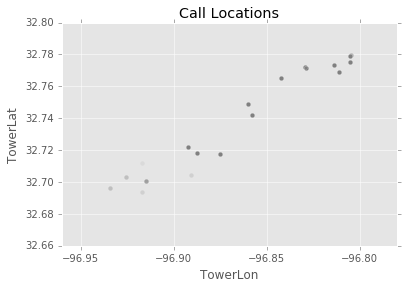

In [91]:
#
# TODO: Plot the Cell Towers the user connected to
#

user1.plot.scatter(x='TowerLon', y='TowerLat', c='gray', alpha=0.1, title='Call Locations')
#showandtell()

[[ 32.74681194 -96.8541221 ]]


2894365987

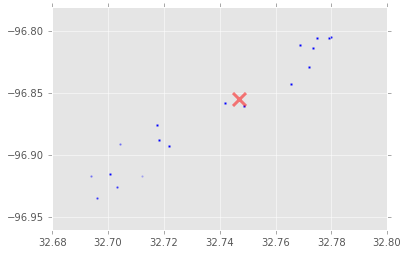

In [93]:
#
# INFO: Run K-Means with K=3 or K=4. There really should only be a two areas of concentration. If you
# notice multiple areas that are "hot" (multiple areas the usr spends a lot of time at that are FAR
# apart from one another), then increase K=5, with the goal being that all centroids except two will
# sweep up the annoying outliers and not-home, not-work travel occasions. the other two will zero in
# on the user's approximate home location and work locations. Or rather the location of the cell
# tower closest to them.....
#

model = doKMeans(user1, 3)
lst_users[4]

In [67]:
#
# INFO: Print out the mean CallTime value for the samples belonging to the cluster with the LEAST
# samples attached to it. If our logic is correct, the cluster with the MOST samples will be work.
# The cluster with the 2nd most samples will be home. And the K=3 cluster with the least samples
# should be somewhere in between the two. What time, on average, is the user in between home and
# work, between the midnight and 5pm?
#

midWayClusterIndices = clusterWithFewestSamples(model)
midWaySamples = user1[midWayClusterIndices]
print "    Its Waypoint Time: ", midWaySamples.CallTime.mean()


  Cluster With Fewest Samples:  0
    Its Waypoint Time: 

TypeError: Could not convert 18:32:47.73501021:05:55.12137707:46:21.60206421:07:34.10578507:02:32.38635222:36:23.72047806:30:46.07442908:55:15.96038316:39:36.79991507:54:12.91097710:58:41.82353920:00:02.58346321:33:21.01386408:21:05.19779709:10:35.06391415:31:20.86457308:35:29.62786518:14:32.84836417:34:44.08912914:57:54.72614308:09:19.46748519:14:09.57944910:12:54.61113814:22:31.14266007:23:01.44241620:25:56.19522812:22:28.54818307:29:11.47443718:07:51.43474618:51:39.03483410:14:57.92718907:14:01.49827815:24:39.70722906:47:40.61881618:45:32.29017520:48:55.60106318:26:29.80823418:45:03.16760506:36:54.40278109:56:20.47560407:17:44.12580819:05:16.68260219:51:26.97160113:07:51.44312220:54:27.95293118:06:26.92551617:28:06.19298208:32:48.32520819:44:36.10761409:02:04.89878007:39:41.60734622:10:33.22965718:49:41.58374419:12:28.52853208:13:59.42852016:44:11.23527720:05:52.70417109:32:35.75986016:14:10.16613020:41:30.23315818:56:14.42951608:06:35.50614208:14:19.12052920:43:30.97633819:58:21.93367919:38:16.13265809:20:17.28046817:14:11.28733119:45:06.73478718:57:51.10318518:40:40.02706908:18:28.38279208:22:06.13940116:03:35.46062113:01:41.36398717:38:46.07439418:44:16.50049410:37:19.70160019:12:34.20320807:32:28.28247308:07:03.62653807:10:03.02144419:26:07.06463620:29:01.04294421:05:43.80245520:13:07.01762818:40:53.28974608:07:27.01383007:24:21.49206616:49:17.29869508:43:40.07155508:11:45.25076307:39:03.05130007:05:10.79948907:40:57.49290008:05:35.61286915:05:10.60277921:04:55.44093006:52:16.36275719:22:15.71546818:34:15.96251906:35:12.94649807:56:42.73546212:37:29.48093620:20:49.41266821:01:27.93211316:04:39.28029019:01:54.11281008:01:13.02807208:27:29.28792219:56:16.77724507:29:36.96377319:53:03.57551007:49:56.22464307:27:31.55072619:29:40.27988019:22:50.37219019:58:33.49489819:05:02.54930716:36:57.92206617:49:57.25474511:50:03.71253620:27:58.34741118:53:36.02535507:04:04.21549911:36:34.78777120:18:14.94390416:08:19.25032515:44:58.51222121:55:32.53075807:32:04.84376606:54:17.88757419:41:21.84419609:09:08.11184522:49:49.72271406:13:32.15100908:38:22.16551518:31:41.94852307:26:41.64338521:07:04.26145121:10:24.39844507:01:51.00760815:37:51.63562206:46:29.81372610:13:43.30347921:40:39.29201719:54:25.15476417:00:43.74147107:54:42.43854619:33:51.18619119:24:32.27040518:06:34.67269308:55:24.86070018:04:18.61875219:19:27.36057117:07:18.90462418:05:55.99849819:36:41.26352607:26:03.11894208:20:17.49890209:17:49.05017508:46:22.90063117:32:12.38489419:04:03.45355706:03:10.35368819:57:03.30578117:33:13.54408618:17:22.55013612:00:31.28908420:13:39.71712617:00:51.70543718:10:16.13679519:55:35.92227307:57:06.38879107:44:10.93356018:35:56.33301112:52:50.77417117:00:03.82005617:59:30.84789519:40:29.95995007:00:57.68269608:07:19.01093919:09:24.21174620:43:29.05231711:09:49.75098507:54:38.67809606:59:35.32455815:32:31.21165921:09:58.20607209:37:48.60505408:22:44.85153119:02:40.44391807:39:57.75167214:49:50.40451619:05:50.66481320:25:45.91553819:00:53.24317419:22:50.25193418:53:07.00452407:58:29.33492919:54:58.46617220:14:28.06432515:26:00.47042109:01:31.38798314:07:42.62541308:15:27.36303719:17:29.38737018:41:47.42500507:41:33.08525813:49:34.44716621:11:04.86044607:39:18.66205218:30:01.31785615:59:30.08477808:51:16.77909618:55:14.34268507:30:51.19920108:56:56.31657708:13:03.62194808:35:26.80596709:30:39.27096421:29:37.80460908:31:10.00976708:03:35.90878013:11:34.12518908:10:20.02507808:25:23.74222914:13:57.74759614:41:29.44844309:56:15.63178606:58:47.25200508:04:59.98426312:08:04.59268319:01:21.29391917:08:03.59263209:47:46.82559317:44:51.73797916:15:05.57524308:15:17.94133209:49:34.23857020:40:56.08455318:40:09.92133807:32:08.39546607:10:23.47591020:52:18.85552818:49:58.17364409:50:46.07234608:39:38.10573815:38:43.77858119:31:23.82736407:01:50.50860021:42:34.61380217:21:58.14477914:02:41.83720908:33:17.74724307:15:56.89523719:42:15.20081517:40:47.91133919:54:24.16575818:35:06.28009608:58:07.23474206:56:32.41250506:37:39.89236016:59:30.48998617:58:16.44484508:31:41.19708809:25:22.02164920:06:30.07216306:50:24.76538814:00:39.33485410:55:40.16569717:31:12.18481809:12:25.61635411:00:46.27422720:47:22.04904606:30:29.48942817:31:18.42960907:19:15.61664819:33:58.55014806:18:49.51214621:30:15.49156112:49:29.14393918:13:11.80744207:40:09.89390319:14:26.48402209:41:05.69786407:49:24.65183420:21:57.88055808:08:25.27006919:34:38.40574515:27:05.83222507:02:33.01226806:04:29.73533708:02:55.16549118:09:11.90977516:22:09.07239116:42:43.16656222:41:24.61452007:38:39.66363908:57:54.22746415:51:19.93040807:00:44.43463919:10:49.22290906:51:55.71984819:41:26.46316518:39:06.42191809:14:42.85765608:02:14.31735219:33:38.95684407:02:17.74167216:32:15.59886810:19:03.55271320:09:00.12522817:20:21.02411518:19:09.44320918:57:10.02666107:34:34.62655516:11:39.44538408:11:25.22312116:07:05.23899207:15:45.43313917:50:18.72877508:35:51.27755918:47:56.47438014:56:36.82314720:13:36.34477719:23:33.30432017:41:12.59697722:37:04.03876907:45:56.33564022:27:46.35427615:33:10.46498820:34:14.75413420:16:42.96483519:24:36.31534508:56:45.26792908:29:18.26674320:31:57.99406719:02:05.88405508:56:26.99123707:33:51.03651018:27:51.01012319:03:08.72325909:03:18.11627611:49:12.96056917:46:37.49125307:52:20.72121308:01:12.54486111:29:51.88173820:12:02.15978918:37:20.59349107:40:33.99224119:43:50.31290718:27:08.05087907:57:35.04537916:28:11.32581819:40:35.28111507:40:44.91753908:47:16.81937607:54:44.62190318:01:04.33972420:38:13.05295219:48:05.59083616:22:06.01136406:18:01.74531909:03:43.88521217:39:38.77539510:40:34.51356718:52:32.52801720:59:29.05047820:34:04.90673519:32:38.79343421:58:39.63734712:54:29.81253508:13:52.89038820:35:37.29452807:34:48.92636617:46:53.82509308:01:08.90745906:40:48.84620006:35:19.11342012:06:33.06264716:58:55.46432808:05:35.71211120:02:13.39264707:01:01.46802706:57:36.10746718:23:23.31507219:37:35.38443007:40:46.51101815:50:58.30031516:15:15.70315107:03:34.89632107:48:23.56818707:24:16.43654214:35:34.21969208:47:39.88814207:29:41.34583521:49:44.84916611:42:07.95899617:27:26.45906320:01:58.74269608:27:06.51561806:23:12.79060716:53:12.19903211:39:04.22259907:44:39.41453507:51:46.61508817:48:49.75035620:23:27.06986108:55:04.38328717:40:04.84082106:45:11.15404007:01:05.21214308:29:14.17681818:13:06.44592812:50:36.11787920:03:10.21228317:39:19.34942413:33:33.39607209:05:44.68850408:13:43.84082416:34:41.32602118:17:49.60438219:18:00.61677407:44:03.72168516:41:34.67402218:35:18.68822008:28:15.22773007:55:40.00933912:48:02.00875607:20:20.71568416:28:12.56750216:11:07.03284118:39:02.13885418:56:41.07817519:36:18.08055807:18:34.52713808:05:53.35535318:57:55.38991915:00:06.70946416:09:40.70031117:24:10.89193818:09:40.85380907:20:00.28721008:00:28.13233619:17:52.25632511:11:21.84411708:12:57.99240207:32:57.87220518:06:37.80974308:28:01.51418420:51:39.21801611:18:40.60946118:22:05.82257507:42:45.83453110:32:20.97284020:21:01.21387709:11:38.95998512:34:51.62859417:57:52.17017518:58:46.69058012:26:06.47202107:10:15.18602907:42:33.34112406:17:41.70432517:46:23.64315509:44:34.81689108:10:06.10548508:51:11.88030122:45:16.88623719:07:54.14821908:59:20.70964819:00:25.15520516:37:29.25703206:38:04.69254908:31:08.48786606:37:05.54752808:13:02.54425318:54:51.51629217:21:19.94850507:26:24.68842608:16:58.28848117:01:16.45961518:39:49.72525110:14:01.63802818:37:29.17720507:32:20.74527309:20:23.88527107:52:55.74649921:17:16.55236311:10:04.85894617:54:41.27032808:22:59.16954819:49:20.43147316:40:37.79485009:10:49.44753019:41:16.23362007:31:45.25123306:28:48.25060809:06:16.81194509:36:30.90976916:39:03.48471908:09:11.28000920:02:32.93379522:31:57.78435209:17:45.90145920:54:37.15602318:19:58.01256018:59:48.95498309:27:52.30887319:48:03.90215007:33:11.25159310:22:07.36420819:08:11.74271318:53:26.93667808:21:54.83183713:50:49.27639209:11:30.50976009:44:43.36029319:36:44.40275817:53:15.14225210:15:09.39188919:15:39.00470619:18:34.00030908:47:37.76322910:24:47.70278517:49:43.79708307:32:53.39680007:01:00.75196108:37:36.39026218:01:56.78339919:31:38.01226210:00:18.89235418:16:15.36271320:05:23.87733918:16:04.50515108:32:41.19290319:47:06.13843207:31:07.96287719:18:03.51336120:17:07.24073708:38:14.75261609:07:44.66367418:19:47.43219808:16:53.52963615:01:03.84887707:14:34.58404719:56:17.03078622:39:16.15758614:56:14.18387220:20:30.00235822:54:01.84744410:43:41.85098518:24:00.87082911:04:42.76153718:28:51.49266319:02:18.71003108:27:04.90296619:31:31.52374819:45:39.40635107:44:04.32660808:27:56.81941120:24:04.50733607:31:27.85619809:01:42.09758117:38:23.39810308:20:01.00134208:21:09.08120615:35:14.94834907:27:58.35265022:58:47.82571807:52:01.81983518:03:46.59510719:09:52.51172307:52:14.65885417:09:24.21987308:17:56.67639119:51:42.86433722:38:35.82231518:45:18.51052312:58:31.51961709:18:41.78519808:49:07.41509817:38:10.80166016:58:23.06123417:39:39.47323608:06:49.06817817:20:04.43840119:43:17.70310510:11:24.57517617:05:40.40878419:58:45.20479613:48:34.38748407:14:16.62508008:43:40.23458910:14:49.18116812:39:03.85300918:07:55.95389408:42:16.97238318:47:25.92645908:08:13.21822208:32:46.57405117:21:33.75070520:09:18.41016922:48:08.78469207:30:14.32941711:21:27.10706011:26:55.85956419:13:24.00892608:22:02.63520608:25:26.81596508:07:23.06914521:29:06.15975318:51:26.94169510:31:26.55308307:02:04.49905607:51:45.70935106:58:33.11992619:01:26.12073118:02:05.31719819:13:01.47952421:33:53.57778917:53:37.13994606:19:13.00981919:33:48.04769108:49:11.39315807:30:25.21037819:42:53.27431508:40:09.09647818:44:43.07753517:16:08.50805607:40:53.87936421:07:44.10360007:51:00.78622707:32:03.32118207:46:52.98421708:57:17.50111507:54:04.64766610:14:18.13977019:33:51.16113212:28:22.24091708:27:41.09647109:15:29.79323911:13:28.41102807:36:11.94510818:42:48.04036512:25:54.82271119:41:03.15440008:09:57.20702708:41:01.61218320:10:22.33895912:35:20.64304107:30:02.89564515:24:20.19232107:22:59.73376009:26:00.13299511:55:45.75160207:57:48.74422019:26:58.87798910:01:05.25877207:33:47.76250421:24:29.30125407:41:00.70676507:42:29.06010606:57:40.42908408:02:16.21027307:32:53.85335219:27:42.68428718:16:04.14120721:51:32.28609707:26:48.02932106:57:41.43070808:32:57.05538107:47:58.16363418:23:14.92060707:57:00.70296419:35:54.56976107:02:03.92100007:14:33.54454217:43:34.49003908:36:15.60126407:46:57.39994018:11:41.58010908:32:39.59100208:03:50.14931507:38:31.45705708:01:54.24573621:01:23.51677009:37:59.25089009:01:04.58419708:44:37.42807720:04:49.62168212:13:25.36030705:10:02.53267407:31:57.08644220:18:08.93232009:14:19.08660022:28:21.83774809:12:10.02473706:28:59.84933606:49:02.14816907:41:34.82759408:07:59.95165008:56:51.07786408:34:17.06267307:55:37.68091319:32:43.04006320:04:39.82556419:57:27.90953918:56:51.04347017:11:36.01681008:04:47.59914517:54:32.62748314:41:25.76355716:07:38.64770506:55:59.43513121:20:49.17232314:41:33.95676020:51:41.37233608:02:05.22180108:24:55.10773716:49:47.51146108:07:08.77253716:53:12.52351515:06:29.67179207:25:32.52584519:44:09.77496208:02:43.25855620:31:47.84122919:44:28.73176420:35:57.86254208:16:36.75265308:32:14.17135509:10:48.77918011:25:49.87232120:13:25.55701708:54:01.07456315:56:22.89244119:50:52.21298509:05:56.61276019:56:57.90837008:47:26.37678417:02:03.38031315:52:48.47666808:10:08.97461108:41:32.64110812:14:16.05424220:06:23.71880006:28:38.95796722:13:29.52718614:22:11.88507517:24:04.72654319:33:21.67269806:01:42.86979507:06:37.58633520:08:00.96762920:28:14.93813807:22:46.53738108:22:53.21232617:47:34.52733706:57:39.04238518:28:44.40957007:52:17.44936620:01:36.30594806:55:25.43601614:24:02.80129708:47:27.62879207:21:37.65046409:03:06.97585107:26:57.35774213:52:01.15237808:45:21.23394809:03:00.87481320:05:31.65304908:19:17.49791607:37:31.29863718:20:50.80435216:49:10.90630109:08:05.18118507:48:07.46783820:28:51.43837113:32:37.86145818:20:57.36932619:55:54.39374319:26:41.32694515:06:35.56708819:28:29.20300420:53:04.53919018:01:24.24098420:07:50.16641318:56:44.83915319:26:15.21703117:09:35.89046110:33:21.39548718:20:26.10835910:09:15.65624320:22:10.06573610:54:18.59640009:11:23.30464508:55:56.04860508:49:50.82990618:42:33.67911308:23:05.06355109:30:37.53577812:15:44.88014711:55:33.39412621:57:39.83489019:37:27.64871508:21:01.05010020:50:47.49869707:13:45.95473214:46:27.87325320:16:27.44133708:18:41.27061709:50:57.53034606:59:31.11097718:54:11.05265408:12:05.88601019:12:02.39435708:31:42.49263706:09:23.76129307:28:17.92315108:32:59.28102809:25:28.64890813:26:17.41644419:01:58.61095211:05:23.21462320:44:32.94623008:13:57.11861916:53:24.49558007:55:36.79017307:30:52.28628118:13:16.25276415:13:01.19729416:25:06.42845719:55:36.26324207:41:49.81581118:53:36.08368109:46:49.56523220:18:32.99800908:05:46.22366518:54:25.18097014:56:26.29357411:39:12.95772907:59:04.50674907:15:10.90753918:21:28.77896907:48:22.18448120:05:25.59387118:59:37.45972709:04:53.43664017:09:17.47763219:55:38.04011008:05:59.73139410:41:13.39803420:01:09.45736717:37:40.11046217:29:50.43674114:57:52.09837415:09:43.39319115:20:18.42444907:18:26.36596008:11:17.85081907:27:37.83047308:40:43.80555420:01:57.09582707:34:16.49384309:12:53.23229917:23:35.66002206:50:41.86490622:23:15.24200319:21:56.33635719:21:35.66104908:00:06.55275308:43:13.38636319:30:41.54845118:11:42.81449119:03:14.29249408:11:41.77065716:52:31.62168018:23:29.00636206:53:56.00800219:37:37.98071107:43:43.88380208:38:25.94377019:51:30.38724606:40:48.40355608:11:06.88043118:39:56.07681318:08:14.34336808:11:34.71410407:55:23.20281719:20:46.35461619:55:54.90781508:54:59.87404716:51:47.06332411:59:21.49524006:31:06.86678607:42:32.87538715:40:05.98509619:20:29.65609522:40:45.60501113:39:08.86230418:19:56.60133508:19:44.69927418:37:44.19058508:05:54.60261619:05:55.29955921:51:22.06342620:48:13.78241021:26:10.11840707:05:57.51520318:40:03.74096208:53:29.63168716:44:29.67204816:53:15.53914214:30:22.19704518:20:01.79027520:49:04.66732416:40:25.35987318:52:28.52762308:30:19.88323107:02:31.06461710:14:01.32952620:15:11.63394121:05:50.71546620:01:42.44853721:50:08.34383406:37:05.23422217:55:15.94024609:43:23.48932016:13:09.03299919:01:25.33224018:12:51.74091409:09:06.63853516:26:52.80491507:03:57.64107319:56:19.79712118:48:56.28894411:29:06.38499218:48:47.18790106:52:38.25673519:47:08.08718719:26:15.93892214:56:00.31368406:12:56.14638115:18:43.90329118:25:07.09524105:34:34.39892009:26:23.74600206:12:16.97791619:23:22.26482311:24:21.12779316:55:18.83537710:18:28.15095807:34:38.64743613:54:30.42745518:13:04.07500209:12:34.74976917:53:47.55436708:18:00.61156107:28:43.87433807:25:16.63296218:29:22.04611308:37:57.50069909:32:58.51452307:23:14.93573908:35:23.76100505:48:20.07313807:24:51.71088417:49:24.60983408:32:23.41927418:08:19.26157820:45:57.94320915:47:15.37343117:14:53.74009606:37:34.91771107:19:45.70061218:44:34.60433709:06:22.21670921:24:41.63623019:11:39.70574311:33:34.75917120:22:51.43358306:49:16.31308015:42:11.72909109:11:08.16069120:48:05.53855906:36:29.36668206:42:25.26356620:57:31.52277007:44:55.17167220:01:30.43676018:54:09.18901719:34:26.80102210:02:09.42004820:25:16.41092011:14:17.96753211:47:17.73529907:26:47.08531708:46:22.70640819:05:37.11496820:16:41.93289013:38:47.20396021:07:33.99637918:18:21.59879321:46:25.94574009:06:22.39222414:07:19.40552918:19:16.39843718:36:05.74255519:38:37.63367510:57:50.01428921:16:57.12763407:53:25.26845114:34:17.95814208:35:48.46753408:26:10.05393617:05:56.10943618:35:46.63601208:11:33.12786418:36:57.05752206:15:18.45495407:45:30.94399218:54:22.96117219:58:46.38230208:24:25.94660307:22:32.61620811:48:30.10360008:14:26.93225918:32:47.87279107:59:11.81452109:12:36.00845307:13:02.74663415:25:55.30477406:10:17.09865408:05:25.75302821:07:03.02047119:45:34.21212608:39:53.64276511:03:17.75205021:18:13.87363622:24:19.17050607:43:28.66498621:02:59.30568618:58:08.92115622:34:21.27419517:41:30.83674808:58:29.55467307:26:09.02544707:26:50.44343307:41:25.24694716:15:41.92219507:19:19.63609319:03:29.66079719:59:47.01254407:32:25.29252919:32:07.66726716:00:23.84319508:35:11.76272719:45:36.31671318:23:04.79570807:27:59.70725912:35:08.62331407:32:28.74032306:50:43.49568218:25:30.13282722:39:30.05884207:44:57.67982208:14:01.30421808:46:10.49049220:20:45.33610920:51:38.40575918:02:45.24961708:27:28.05138019:08:03.39070017:35:53.01863107:59:17.22122608:55:01.90158316:29:58.15907611:23:51.94461517:56:16.09823220:19:53.78922909:03:29.82078708:33:46.67126108:01:46.41523422:41:10.59554519:03:59.65459808:40:34.39950117:57:36.95894617:24:27.45545418:56:50.18498308:04:31.03624218:02:39.40650719:31:18.70333717:43:50.37148707:15:33.03960210:59:01.18539119:11:18.98639721:30:58.85176520:47:07.10640820:05:31.19135421:19:53.40710110:04:06.87565706:16:47.75549017:46:19.24944709:10:43.27763118:54:50.07397311:01:55.72981808:05:13.74356506:56:00.92470808:06:02.79404921:10:07.81233107:15:46.89402619:48:51.74935309:01:11.83642420:28:40.77715907:43:35.93157307:36:25.92297708:46:55.20499117:19:32.26808819:41:45.61778119:10:51.56011608:13:21.75456106:15:01.52553818:46:17.41676617:41:35.20233907:56:10.44561318:07:33.71548008:24:32.98530108:10:12.31390313:41:03.23160308:34:56.78430208:28:38.71531918:05:42.16882619:13:17.94009808:44:21.81118817:00:32.45820119:28:23.419066 to numeric

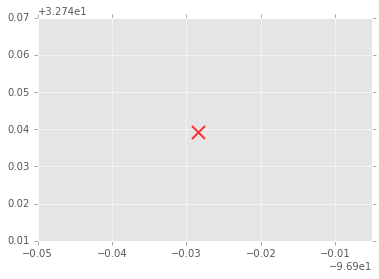

In [16]:
#
# Let's visualize the results!
# First draw the X's for the clusters:
#

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(model.cluster_centers_[:,1], model.cluster_centers_[:,0], s=169, c='r', marker='x', alpha=0.8, linewidths=2)

#
# Then save the results:
#showandtell('Weekday Calls Centroids')  # Comment this line out when you're ready to proceed